# CCCA Data Centre Iris and Pandas with OpenDAP
## Workshop Notebook 3

### Original notebook from:

Georg Seyerl (georg.seyerl@ccca.ac.at)

### Further Information:

[**Iris Documentation**](http://scitools.org.uk/iris/docs/latest/index.html)

[**Pandas Documentation**](https://pandas.pydata.org/pandas-docs/stable/index.html)

[**Numpy/Scipy Documentation**](https://docs.scipy.org/doc/)

================

In [1]:
import iris
import iris.coord_categorisation
import iris.quickplot as qp
import iris.pandas
from iris.experimental.equalise_cubes import equalise_attributes

from pprint import pprint
import numpy as np
import pandas as pd
import cf_units
import matplotlib.pyplot as plt
from datetime import datetime
from ckanapi import RemoteCKAN

import warnings
warnings.filterwarnings('ignore')

# Load Metadata from Server

Create a RemoteCKAN object from the module ckanapi. The apikey identifies the user.

In [2]:
data_ccca = RemoteCKAN('https://data.ccca.ac.at', apikey='54cc28ea-5391-4e87-8ebf-d1b231e5b52b')

Search for packages in groups bias-corrected and rcp45, but only for the variables Air Temperature (mean).

In [3]:
pkg_list_oks15_tas = data_ccca.call_action(
    'package_search', 
    {'fq':"groups:bias-corrected AND groups:rcp45 AND extras_specifics_Variables:Air?Temperature?\(mean\)", 
     'rows':1000}
)

In [4]:
pprint(pkg_list_oks15_tas.keys())

dict_keys(['count', 'sort', 'facets', 'results', 'search_facets'])


Create list with OpenDAP urls (strings) for the resulting packages from the search above.

In [5]:
ls_res_url = [
    [res['url'].rsplit('.',1)[0] for res in pkg['resources'] if "dap" in res['name'].lower()][0] 
    for pkg in pkg_list_oks15_tas['results']
]
pprint(ls_res_url)

['https://data.ccca.ac.at/thredds/dodsC/ckan/a7f/241/93-3992-4819-ab70-99219855a0fd',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/d1c/37f/cf-1032-4648-b1e0-fbaf09b9b6b5',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/293/ead/0f-f885-440d-ae76-efcb0d32bde0',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/49d/dac/f8-d1c6-4e3a-8faa-94a021583ea5',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/5c9/c8c/12-29e0-4dfa-ba8b-0d1b3dd4ef03',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/815/723/70-ee31-47c0-8215-83f293718f8c',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/923/a51/bb-2162-4d68-b2bb-b0acd02c54ab',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/1e9/aec/87-0022-4b7a-bd67-f4c2667fd2d7',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/f2c/d5e/8a-87ef-4f12-a07a-601403835b54',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/ff8/4e6/15-b4cc-4797-a2b0-46a2a3d34492',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/47a/051/c1-ddbd-462c-acde-8befb58817fe',
 'https://data.ccca.ac.at/thredds/dodsC/ckan/5fc/295/b

Create list with ensemble member names for the resulting packages from the search above.

In [6]:
ls_realization_name = [pkg['name'].split('_',5)[-1].rsplit('-',1)[0] for pkg in pkg_list_oks15_tas['results']]

# Load data as iris cubes (CubeList)

Define a function to add a scalar dimension realization when we load the datasets.

In [7]:
realization = 0

In [8]:
def lagged_ensemble_callback(cube, field, filename):
    # Add our own realization coordinate if it doesn't already exist.
    if not cube.coords('realization'):
        global realization 
        realization += 1
        ensemble_coord = iris.coords.AuxCoord(realization, standard_name='realization')
        cube.add_aux_coord(ensemble_coord)

## Load the data with iris:
- Constraint on time (use 30 year time span)
- Constraint on space (use 5x5 field)
- Add realization number with iris callback method

In [9]:
#ls_oks15_test = iris.load([url for url in ls_res_url], 
#                       iris.Constraint(time=lambda cell: datetime(2020,1,1,0) <= cell.point <= datetime(2049,12,31,23),
#                                       projection_y_coordinate = lambda cell: 395500 <= cell < 400500,
#                                       projection_x_coordinate = lambda cell: 361500 <= cell < 366500),
#                       callback=lagged_ensemble_callback)
ls_oks15_test = iris.load('data/oks15/*.nc')

The data is lazy (not in memory).

In [10]:
ls_oks15_test[0].has_lazy_data()

True

Contourplot of the first timeslice in first cube of the loaded CubeList

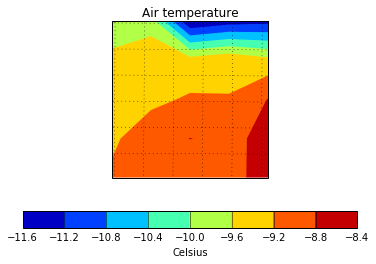

In [11]:
qp.contourf(ls_oks15_test[0][0,:,:])
ax = plt.gca()
ax.gridlines()
qp.show()

## Average over space and time
- Add a new coordinate month
- Add a new coordinate year
- Spatial averaging
- Monthly averaging
- Unify time coordinate after calculations (different calendars)

In [12]:
ls_oks15_monthly = iris.cube.CubeList()
ls_oks15_monthly_anom = iris.cube.CubeList()

for idx, oks15_test in enumerate(ls_oks15_test):
    iris.coord_categorisation.add_month(oks15_test, 'time', name='month')
    iris.coord_categorisation.add_year(oks15_test, 'time', name='year')
    oks15_test = oks15_test.collapsed(['projection_y_coordinate','projection_x_coordinate'],iris.analysis.MEAN)
    ls_oks15_monthly.append(oks15_test.aggregated_by(['month'],iris.analysis.MEAN))
    ls_oks15_monthly_anom.append(
        oks15_test.aggregated_by(['month','year'],iris.analysis.MEAN)
    )
    
    if idx != 0:
        ls_oks15_monthly[idx].remove_coord('time')
        ls_oks15_monthly[idx].add_dim_coord(ls_oks15_monthly[0].coord('time'), 0)
        
        ls_oks15_monthly_anom[idx].remove_coord('time')
        ls_oks15_monthly_anom[idx].add_dim_coord(ls_oks15_monthly_anom[0].coord('time'), 0)

Unify attributes and dimensions for all cubes in CubeList. Merge the cubeList to create a new cube with dimension realization.

In [13]:
for oks15_monthly in ls_oks15_monthly:
    try:
        oks15_monthly.coord('month').attributes = {}
        oks15_monthly.coord('year').attributes = {}
        oks15_monthly.remove_coord('height')
    except:
        pass
    
equalise_attributes(ls_oks15_monthly)
ls_oks15_monthly = ls_oks15_monthly.merge_cube()
print(ls_oks15_monthly.summary(True))

air_temperature / (Celsius)         (realization: 13; time: 12)


In [14]:
for oks15_test in ls_oks15_monthly_anom:
    try:
        oks15_test.coord('month').attributes = {}
        oks15_test.coord('year').attributes = {}
        oks15_test.remove_coord('height')
    except:
        pass

equalise_attributes(ls_oks15_monthly_anom)
ls_oks15_monthly_anom = ls_oks15_monthly_anom.merge_cube()
print(ls_oks15_monthly_anom.summary(True))

air_temperature / (Celsius)         (realization: 13; time: 360)


Remove monthly mean from timeseries to calculate anomalies

In [15]:
tile_dimensions = (1, int(ls_oks15_monthly_anom.coord('time').shape[0]/ls_oks15_monthly_anom.coord('time').shape[0]))
ls_oks15_monthly_anom.data = ls_oks15_monthly_anom.data - np.tile(ls_oks15_monthly.data, (1,30))

Slice over realization dimension and plot monthly means for all ensemble members.

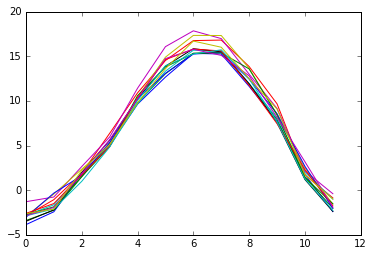

In [16]:
for oks15_monthly in ls_oks15_monthly.slices_over('realization'):
    plt.plot(oks15_monthly.data)
qp.show()

Slice over realization dimension and plot monthly anomalies for all ensemble members.

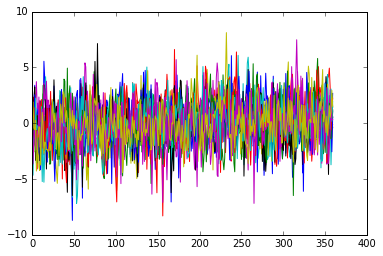

In [17]:
for oks15_monthly_anom in ls_oks15_monthly_anom.slices_over('realization'):
    plt.plot(oks15_monthly_anom.data)
qp.show()

Save anomalies as cf conformal netcdf file.

In [18]:
iris.save(oks15_monthly_anom,'oks15_monthly_anom_near_future.nc')

# Blend with pandas

Define helper function as_series to convert an iris cube object into a pandas data series with index as method argument. 

In [19]:
import pandas
from iris.pandas import _as_pandas_coord

def as_series(cube, index=None, copy=True, name=None):
    data = cube.data
    if isinstance(data, np.ma.MaskedArray):
        if not copy:
            raise ValueError("Masked arrays must always be copied.")
        data = data.astype('f').filled(np.nan)
    elif copy:
        data = data.copy()

    if not index:
        if cube.dim_coords:
            index = _as_pandas_coord(cube.dim_coords[0])
    else:
        index = _as_pandas_coord(index)

    series = pandas.Series(data, index, name=name)
    if not copy:
        _assert_shared(data, series)

    return series

Convert the monthly means of every realization to pandas series and append to a list. Concatenate the list to create a pandas DataFrame.

In [20]:
ls_pd_series = list()
for idx, oks15_monthly in enumerate(ls_oks15_monthly.slices_over('realization')):
    ls_pd_series.append(as_series(oks15_monthly, ls_oks15_monthly.coord('month'), name=ls_realization_name[idx]))
df_pd_monthly_mean = pd.concat(ls_pd_series, axis=1)

Take a look in the DataFrame.

In [21]:
df_pd_monthly_mean

,mpi-m-mpi-esm-lr_rcp45_r1i1p1_smhi-rca4,mpi-m-mpi-esm-lr_rcp45_r1i1p1_clmcom-cclm4-8-17,mohc-hadgem2-es_rcp45_r1i1p1_clmcom-cclm4-8-17,mohc-hadgem2-es_rcp45_r1i1p1_smhi-rca4,ipsl-ipsl-cm5a-mr_rcp45_r1i1p1_smhi-rca4,ipsl-ipsl-cm5a-mr_rcp45_r1i1p1_ipsl-ineris-wrf331f,ichec-ec-earth_rcp45_r3i1p1_dmi-hirham5,ichec-ec-earth_rcp45_r12i1p1_clmcom-cclm4-8-17,ichec-ec-earth_rcp45_r1i1p1_knmi-racmo22e,ichec-ec-earth_rcp45_r12i1p1_smhi-rca4,cnrm-cerfacs-cnrm-cm5_rcp45_r1i1p1_smhi-rca4,cnrm-cerfacs-cnrm-cm5_rcp45_r1i1p1_cnrm-aladin53,cnrm-cerfacs-cnrm-cm5_rcp45_r1i1p1_clmcom-cclm4-8-17
Jan,-3.860380,-3.398478,-2.877711,-2.812445,-1.293779,-2.932919,-3.490816,-3.032093,-2.757498,-2.603512,-2.875542,-2.852913,-2.636348
Feb,-2.420815,-2.249613,-1.062037,-1.644295,-0.765950,-0.428679,-2.203719,-0.328443,-1.865394,-1.500793,-2.103448,-1.938989,-2.121313
Mar,1.864914,1.499980,1.883545,1.900664,2.646040,2.350669,1.977799,1.628459,1.521308,1.714269,0.987640,1.873903,2.208462
Apr,5.038952,5.261393,6.364003,4.908045,5.953920,5.075903,5.582626,5.334650,4.875025,4.890641,4.828337,5.643496,5.113264
May,9.633205,9.795010,10.897007,9.657640,11.418488,10.409676,10.247383,10.225492,10.586367,10.335997,10.045798,10.255160,9.782852
Jun,12.664891,13.041458,14.526628,13.326308,16.072784,14.897416,13.882915,13.089946,13.799806,14.623446,13.941020,14.736762,13.608137
Jul,15.319349,15.333672,16.752274,15.680463,17.846485,17.333803,15.844624,15.244413,15.309258,15.801806,15.255390,15.776288,16.700138
Aug,15.253328,15.467576,16.810829,15.590221,16.976732,17.321596,15.493800,15.424015,15.380912,15.596980,15.717859,15.095869,16.009293
Sep,11.626060,11.889009,13.842335,11.935122,12.985099,13.638727,11.907749,12.441341,13.578104,11.739930,12.465351,12.804269,12.489462
Oct,7.724253,7.911700,9.669538,8.070592,9.152755,8.453490,7.554747,8.565223,8.436643,7.446024,7.623146,8.165547,9.090595


Make a boxplot.

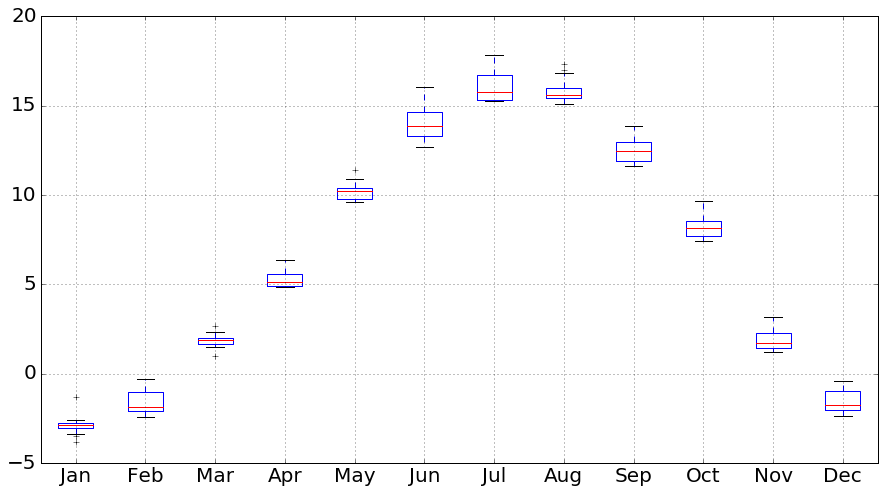

In [22]:
df_pd_monthly_mean.transpose().boxplot(figsize=(15, 8), fontsize=20, grid=True)

Save monthly means of ensemble members as csv.

In [23]:
df_pd_monthly_mean.to_csv('oks15_monthly_mean_near_future.csv', sep=';')